# The Common Coordinate Framework and AllenSDK

The Common Coordinate Framework (CCF) can readily be accessed through the AllenSDK and used to analyze arrays of registered data. 

## Installation
To get started, you can follow [these](https://allensdk.readthedocs.io/en/latest/install.html) instructions to install the AllenSDK:

First install python 3.7
Then install the AllenSDK using PIP:
    pip install allensdk

You can now run the AllenSDK in a jupyter notebook or other environment of your choice. Documentation can be found [here](https://allensdk.readthedocs.io/en/latest/).

## The Mouse Connectivity Cache

The average template volume, annotation volume, and ontology can all be accessed through the Mouse Connectivity Cache. This also provides access to published connectivity data registered to the CCF. First, import the MouseConnectivityCache. Along with this, I will also import numpy and pandas to use for data processing, as well as pyplot for visualization.

In [1]:
import numpy as np
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import pyplot as plt

In [2]:
%matplotlib notebook

### Accessing the CCF from the MouseConnectivityCache

Instantiate the MouseConnectivityCache (mcc). The default resolution is 25 microns, but 10,50, and 100 microns are also valid options. You can also specify a location of a manifest file, which would keep track of all downloaded assets from template and annotation volumes to experimental data. If a manifest file directory is not provided, one will be created in the current working directory.

In [3]:
mcc = MouseConnectivityCache(resolution=25)

#### Annotated Volume and Reference Space
Now you can get the Reference Space (rsp) at that resolution. This automatically downloads the annotated volume at the specified resolution (25 microns).

In [4]:
rsp = mcc.get_reference_space()

The annotated volume is a 3D numpy ndarray, with axes correspond to AP,DV, and ML respectively:

In [5]:
print('Shape of annotated volume:',rsp.annotation.shape)
print('Annotated volume data type:',rsp.annotation.dtype)

Shape of annotated volume: (528, 320, 456)
Annotated volume data type: uint32


The rsp provides access to the structure tree from the ontology. Given that there are multiple atlases and associated ontologies, we are only interested in the structures belonging to this annotation. Thus, we remove unassigned structures from the structure tree. This returns a structure graph which is more easily viewed as a pandas DataFrame:

In [6]:
sg = rsp.remove_unassigned()

In [7]:
sg = pd.DataFrame(sg)

In [8]:
sg.head()

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,root,1,0,997,root,[997],[691663206],"[255, 255, 255]"
1,grey,1,1,8,Basic cell groups and regions,"[997, 8]","[112905828, 691663206, 12, 184527634, 11290581...","[191, 218, 227]"
2,CH,1,2,567,Cerebrum,"[997, 8, 567]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 240, 255]"
3,CTX,1,3,688,Cerebral cortex,"[997, 8, 567, 688]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 255, 184]"
4,CTXpl,1,4,695,Cortical plate,"[997, 8, 567, 688, 695]","[112905828, 691663206, 12, 184527634, 11290581...","[112, 255, 112]"


In [23]:
sg.loc[sg['name'] == 'Cerebellum']

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
695,CB,1,1014,512,Cerebellum,"[997, 8, 512]","[2, 112905828, 691663206, 12, 184527634, 11290...","[240, 240, 128]"


The structures' acronyms, names and IDs can all be linked through the structure graph.

While the rsp can be used to generate sections in the coronal (0), horizontal (1), or sagittal (2) planes:

<IPython.core.display.Javascript object>


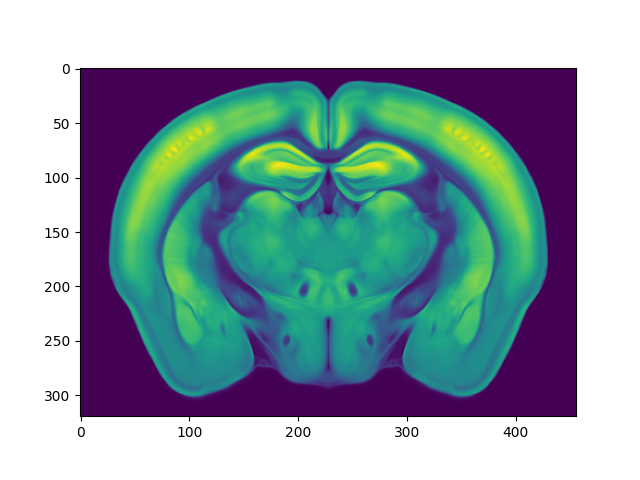

In [24]:
orientation = {'coronal':0,'horizontal':1,'sagittal':2} # makes orientation arguments more readible
pos_microns = lambda x:x*25 # get_slice_image function takes positional arguments in microns instead of 25 micron increments

img = rsp.get_slice_image(orientation['sagittal'],pos_microns(200))
plt.imshow(img)

The rsp can also generate masks of given structure IDs. The IDs are provided as a list, and by default include all voxels annotated as children of the given structures (direct_only=False). If only the parent level voxels are desired, set direct_only to True.

Here we make a mask of the Cerebral Cortex, which from the structure graph is shown to have the ID 688.

In [31]:
ctx_mask = rsp.make_structure_mask([512], direct_only=False)

In [32]:
print('Shape of mask:',ctx_mask.shape)
print('Mask data type:',ctx_mask.dtype)
print('Value of masked voxels:',ctx_mask.max())

Shape of mask: (528, 320, 456)
Mask data type: uint8
Value of masked voxels: 1


In [42]:
midpoint = ctx_mask.shape[2] // 2
plt.imshow(ctx_mask[:,:,midpoint])

The mask is the same shape as the specified reference space, and voxels in that space that belong to the Cerebral Cortex are labeled 1.

#### Average Template Volume
The mcc also provides access to the average template volume, upon which the CCF is constructed. Downloading the template volume puts it in the directory specified by the manifest file when the mcc was instantiated.

In [37]:
avg_temp, meta = mcc.get_template_volume()

In [38]:
print('Shape of average template volume:',avg_temp.shape)
print('Template volume data type:',avg_temp.dtype)
print('Max intensity of template volume:',avg_temp.max())

Shape of average template volume: (528, 320, 456)
Template volume data type: uint16
Max intensity of template volume: 516


In [44]:
midpoint = ctx_mask.shape[0] // 2
print(midpoint)
plt.imshow(avg_temp[midpoint,:,:])

264


### Analysis Using CCF

After accessing the different components of the CCF, we can now use them for analysis. For example, we can sample voxels from any data array in that space using the masks from rsp. To do this, we can simply get the coordinates of the masked voxels and sample our data array with them.

In [16]:
ctx_mask.nonzero()

(array([  1,   1,   1, ..., 416, 416, 416], dtype=int64),
 array([137, 137, 137, ..., 143, 143, 143], dtype=int64),
 array([198, 199, 200, ..., 383, 384, 385], dtype=int64))

In [17]:
avg_temp[ctx_mask.nonzero()]

array([ 4,  4,  4, ..., 69, 69, 70], dtype=uint16)

This resulting array contains the intensity of each voxel in the Cerebral Cortex of the average template volume.

### Accessing Experiments

The mcc also allows us to access published experiments. We can view these as a pandas DataFrame and filter out the data of interest. For example, we can look at all experiments listed as having primary injections in VISp.

In [18]:
exp = mcc.get_experiments(dataframe=True)

In [19]:
exp[exp.structure_abbrev == 'VISp']

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
500836840,M,[385],0.375218,8850,1440,3550,36,Emx1-IRES-Cre-212542,None,VISp,385,Primary visual area,Emx1-IRES-Cre,177836119.0,500836840,385
307297141,M,"[385, 409]",0.663636,9230,1910,8430,5,C57BL/6-152922,C57BL/6J,VISp,385,Primary visual area,None,NaN,307297141,385
272821309,F,[385],0.125424,8690,900,8110,5,Cux2-IRES-Cre-288,C57BL/6J,VISp,385,Primary visual area,Cux2-IRES-Cre,177839022.0,272821309,385
512315551,M,"[385, 409, 425, 894]",1.614223,8460,1630,2340,36,Emx1-IRES-Cre-234272,None,VISp,385,Primary visual area,Emx1-IRES-Cre,177836119.0,512315551,385
510581751,M,[385],0.031653,9230,1390,3070,36,Tlx3-Cre_PL56-232871,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449.0,510581751,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596571282,M,[385],0.001158,9400,1510,8810,5,Oxtr-T2A-Cre;Ai14-318593,unknown,VISp,385,Primary visual area,Oxtr-T2A-Cre,301021674.0,596571282,385
638978767,F,[385],0.006102,8350,590,8160,5,Penk-IRES2-Cre-neo-343079,None,VISp,385,Primary visual area,Penk-IRES2-Cre-neo,298725927.0,638978767,385
503069254,M,[385],0.071099,8690,1440,3090,36,Rbp4-Cre_KL100-227918,None,VISp,385,Primary visual area,Rbp4-Cre_KL100,177838435.0,503069254,385


If we decide to look at the projection densities of a given experiment, we can simply use the mcc to download that data, which will automatically be downloaded at our specified resolution.

In [53]:
projden, meta = mcc.get_projection_density(503069254)

In [54]:
print('Shape of projection density:',projden.shape)
print('Projection density data type:',projden.dtype)
print('Max value of projection density:',projden.max())

Shape of projection density: (528, 320, 456)
Projection density data type: float64
Max value of projection density: 1.0


According to the experiments data frame, this particular experiment has injection coordinates (8690,1440,3090) in microns. Our projden array is in 25 micron space, so we need to convert our coordinates.

In [22]:
8690/25

347.6

In [55]:
plt.imshow(projden[348,:,:]) # indeces must be integers, so we round up from 347.6

### Saving Data

The projection volume can also be written locally to a nrrd file, which can then be viewed by ITK-Snap.

In [24]:
import nrrd

In [25]:
nrrd.write('./projection_density_25_503069254.nrrd',projden)

### Using Masks

Using the masks we create from rsp, we can analyze parcel out the projection densities by annotated structure. For example, we can look at the sum projection density by structure using a loop. We'll have to account for left and right hemispheres, as the masks automatically include both.

In [56]:
print('Number of structures in structure graph:',len(sg.id))

Number of structures in structure graph: 839


There are 839 annotated structures, so this approach can be a little slow. If there are specific structures of interest, it may make more sense to simply sample those. For example, we can look at the projections in the Thalamus and all its substructures.

To find the Thalamus's ID, we can use the structure graph.

In [57]:
sg[sg.name == 'Thalamus']

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
410,TH,1,641,549,Thalamus,"[997, 8, 343, 1129, 549]","[2, 112905828, 691663206, 12, 184527634, 11290...","[255, 112, 128]"


We can also use the structre tree in rsp to find the IDs of all of its descendants (substructures).

In [58]:
print(rsp.structure_tree.descendant_ids([549])[0])

[549, 864, 637, 629, 685, 709, 718, 725, 733, 741, 563807435, 406, 414, 422, 609, 1044, 1008, 475, 1072, 1079, 1088, 170, 496345664, 496345668, 496345672, 856, 138, 218, 1020, 1029, 325, 560581551, 239, 255, 127, 1096, 1104, 64, 1120, 1113, 155, 444, 59, 362, 366, 1077, 571, 149, 15, 181, 560581559, 51, 189, 599, 907, 575, 930, 560581563, 262, 1014, 27, 563807439, 178, 321, 958, 483, 186]


IDs are hard to make sense of, so we can map these back to their acronyms.

In [59]:
id_acronym_map = rsp.structure_tree.get_id_acronym_map() # Dictionary returns IDs given acronyms
acronym_id_map = {v:k for k,v in id_acronym_map.items()} # Flip key:value pairs to get dictionary for acronyms given IDs

In [60]:
print(list(map(acronym_id_map.get,rsp.structure_tree.descendant_ids([549])[0])))

['TH', 'DORsm', 'VENT', 'VAL', 'VM', 'VP', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'PoT', 'SPF', 'SPFm', 'SPFp', 'SPA', 'PP', 'GENd', 'MG', 'MGd', 'MGv', 'MGm', 'LGd', 'LGd-sh', 'LGd-co', 'LGd-ip', 'DORpm', 'LAT', 'LP', 'PO', 'POL', 'SGN', 'Eth', 'ATN', 'AV', 'AM', 'AMd', 'AMv', 'AD', 'IAM', 'IAD', 'LD', 'MED', 'IMD', 'MD', 'SMT', 'PR', 'MTN', 'PVT', 'PT', 'RE', 'Xi', 'ILM', 'RH', 'CM', 'PCN', 'CL', 'PF', 'PIL', 'RT', 'GENv', 'IGL', 'IntG', 'LGv', 'SubG', 'EPI', 'MH', 'LH']


We can now sample our data by thalamic structure and hemisphere. We'll use a hemisphere id of 1 for the left hemisphere and 2 for the right. For the sum of signal in both hemispheres, we'll use a hemisphere id of 3.

In [61]:
sum_projden = []
for ID in rsp.structure_tree.descendant_ids([549])[0]:
    mask = rsp.make_structure_mask([ID])
    
    # left hemisphere
    left = projden[:,:,:228][mask[:,:,:228].nonzero()].sum()
    sum_projden.append({'id':ID, 'acronym':acronym_id_map[ID], 'hemisphere':1, 'sum_projection_density':left})
    
    # right hemisphere
    right = projden[:,:,228:][mask[:,:,228:].nonzero()].sum()
    sum_projden.append({'id':ID, 'acronym':acronym_id_map[ID], 'hemisphere':2, 'sum_projection_density':right})
    
    # both hemispheres
    sum_projden.append({'id':ID, 'acronym':acronym_id_map[ID], 'hemisphere':3, 'sum_projection_density':left+right})

In [62]:
df = pd.DataFrame(sum_projden)

In [63]:
df.head(10)

,id,acronym,hemisphere,sum_projection_density
0,549,TH,1,6063.697628
1,549,TH,2,1.001049
2,549,TH,3,6064.698678
3,864,DORsm,1,981.310728
4,864,DORsm,2,0.065949
5,864,DORsm,3,981.376677
6,637,VENT,1,102.122931
7,637,VENT,2,0.009222
8,637,VENT,3,102.132154
9,629,VAL,1,10.000471


### Accessing Experiments Structure Unionizes

For connectivity data published through the AllenSDK, this has already been done and can be accessed using the mcc.

In [64]:
struct_union = mcc.get_experiment_structure_unionizes(503069254)

In [65]:
struct_union

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,1,640637112,False,0.000000,0,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,503069254,307,4.680124e+10,239999392.0,0.000000e+00,0.000000e+00,0.293999
1,1,640636654,False,0.294172,2870,4100,4850,1.317984e-02,4.414019e-03,5.769497,1307.084961,9.370700e-04,503069254,969,6.882283e+10,173301296.0,9.998613e+08,7.649551e+05,0.212294
2,3,640638251,False,0.106035,6280,870,3070,4.496597e-04,1.744343e-04,0.123628,708.738327,3.197025e-05,503069254,182305693,5.351576e+10,149616000.0,1.849677e+07,2.609816e+04,0.183280
3,2,640635776,False,0.276934,8730,1030,6590,3.117128e-03,2.394871e-04,0.290693,1213.813599,2.216240e-04,503069254,687,3.518189e+11,755437504.0,2.196002e+08,1.809175e+05,0.925411
4,2,640635309,False,0.001005,5790,6890,7820,1.061473e-07,9.152569e-08,0.000055,603.535583,7.546941e-09,503069254,268,3.374464e+10,67311904.0,3.718243e+03,6.160769e+00,0.082457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,1,640636867,False,0.027134,3560,3970,4770,9.316448e-06,1.247779e-04,0.130877,1048.881348,6.623879e-07,503069254,680,7.519174e+08,4333500.0,5.671562e+05,5.407249e+02,0.005309
2548,3,640638683,False,0.303791,6030,1510,4990,1.895807e-02,1.749223e-03,2.019338,1154.420060,1.347896e-03,503069254,919,2.174851e+11,629035200.0,1.270235e+09,1.100323e+06,0.770568
2549,1,640636605,False,0.117985,6550,1880,3520,5.973397e-05,1.051872e-04,0.069200,657.877747,4.247011e-06,503069254,1026,7.880844e+09,32959800.0,2.280828e+06,3.466948e+03,0.040376
2550,1,640636786,False,0.013185,7750,4520,3970,1.908338e-06,1.022085e-06,0.000583,570.256653,1.356805e-07,503069254,804,2.643094e+10,108366304.0,6.316137e+04,1.107596e+02,0.132749


## Structure Sets

While there are 839 unique annotations in CCFv3, these annotations represent structures at different levels of ontology. Structure sets provide a way to access structures at a given level of ontology. For example, 12 high-level structures have been grouped together in a "coarse" structures set and 316 mid-level structures in a "summary" structures set. These sets of structures can be accessed through their structure_set_ids. To find the available structure sets, the OntologiesApi is needed.

In [66]:
from allensdk.api.queries.ontologies_api import OntologiesApi

In [67]:
oapi = OntologiesApi()

In [68]:
structure_sets = pd.DataFrame(oapi.get_structure_sets())

### Coarse Structure Set

In [69]:
structure_sets[structure_sets.name.map(lambda x:'coarse' in x.lower())]

,description,id,name
3,List of structures representing a coarse level...,8,NHP - Coarse
32,List of structures representing a coarse level...,11,Developing Human - Coarse
36,List of structures used for the Developing Mou...,183237650,Developing Mouse - Coarse
40,List of structures representing a coarse level...,4,Human - Coarse
46,List of structures representing a coarse level...,2,Mouse - Coarse


In [70]:
coarse_structures = pd.DataFrame(rsp.structure_tree.get_structures_by_set_id([2]))

In [71]:
coarse_structures

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
1,OLF,1,379,698,Olfactory areas,"[997, 8, 567, 688, 695, 698]","[2, 3, 112905828, 691663206, 12, 184527634, 11...","[154, 210, 189]"
2,HPF,1,454,1089,Hippocampal formation,"[997, 8, 567, 688, 695, 1089]","[2, 112905828, 691663206, 12, 184527634, 11290...","[126, 208, 75]"
3,CTXsp,1,555,703,Cortical subplate,"[997, 8, 567, 688, 703]","[2, 3, 112905828, 691663206, 12, 184527634, 68...","[138, 218, 135]"
4,STR,1,571,477,Striatum,"[997, 8, 567, 623, 477]","[2, 112905828, 691663206, 12, 184527634, 11290...","[152, 214, 249]"
5,PAL,1,608,803,Pallidum,"[997, 8, 567, 623, 803]","[2, 112905828, 691663206, 12, 184527634, 11290...","[133, 153, 204]"
6,TH,1,641,549,Thalamus,"[997, 8, 343, 1129, 549]","[2, 112905828, 691663206, 12, 184527634, 11290...","[255, 112, 128]"
7,HY,1,715,1097,Hypothalamus,"[997, 8, 343, 1129, 1097]","[2, 112905828, 691663206, 12, 184527634, 11290...","[230, 68, 56]"
8,MB,1,806,313,Midbrain,"[997, 8, 343, 313]","[2, 112905828, 691663206, 12, 184527634, 11290...","[255, 100, 255]"
9,P,1,883,771,Pons,"[997, 8, 343, 1065, 771]","[2, 112905828, 691663206, 12, 184527634, 11290...","[255, 155, 136]"


### Summary Structure Set

In [72]:
structure_sets[structure_sets.name.map(lambda x:'summary' in x.lower())]

,description,id,name
13,List of structures used for the HBA gene page,147814064,Human - Summary
14,Structures representing subdivisions of the mo...,687527945,Mouse Connectivity - Summary
21,Curated list of non-overlapping substructures ...,167587189,Brain – Summary Structures
30,List of structures used for the Developing Hum...,157025860,Developing Human - LCM Summary


In [73]:
summary_structures = pd.DataFrame(rsp.structure_tree.get_structures_by_set_id([167587189]))

In [74]:
summary_structures

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,FRP,1,6,184,"Frontal pole, cerebral cortex","[997, 8, 567, 688, 695, 315, 184]","[3, 112905828, 688152357, 691663206, 687527945...","[38, 143, 69]"
1,MOp,1,18,985,Primary motor area,"[997, 8, 567, 688, 695, 315, 500, 985]","[112905828, 688152357, 691663206, 687527945, 1...","[31, 157, 90]"
2,MOs,1,24,993,Secondary motor area,"[997, 8, 567, 688, 695, 315, 500, 993]","[112905828, 688152357, 691663206, 687527945, 1...","[31, 157, 90]"
3,SSp-n,1,44,353,"Primary somatosensory area, nose","[997, 8, 567, 688, 695, 315, 453, 322, 353]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
4,SSp-bfd,1,51,329,"Primary somatosensory area, barrel field","[997, 8, 567, 688, 695, 315, 453, 322, 329]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
...,...,...,...,...,...,...,...,...
311,FN,1,1097,989,Fastigial nucleus,"[997, 8, 512, 519, 989]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
312,IP,1,1098,91,Interposed nucleus,"[997, 8, 512, 519, 91]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
313,DN,1,1099,846,Dentate nucleus,"[997, 8, 512, 519, 846]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 253, 188]"
314,VeCB,1,1100,589508455,Vestibulocerebellar nucleus,"[997, 8, 512, 519, 589508455]","[112905828, 691663206, 688152368, 184527634, 1...","[255, 253, 188]"


## Sample Analysis: Projection Density

As an example, we can now view the projection density across coarse-level structures for all connectivity experiments with primary injection in MOp.

We have our coarse_structure_ids:

In [45]:
coarse_structure_ids = coarse_structures.id.values

In [46]:
coarse_structure_ids

array([ 315,  698, 1089,  703,  477,  803,  549, 1097,  313,  771,  354,
        512], dtype=int64)

From our experiments data frame, we can get experiment ids corresponding to MOp experiments.

In [47]:
MOp_experiments = exp[exp.structure_abbrev == 'MOp'].id.values

Using the mcc, we can get structure unionizes for those experiments in the coarse structures.

In [48]:
MOp_exp_unionizes = mcc.get_structure_unionizes(MOp_experiments,structure_ids=coarse_structure_ids,hemisphere_ids=[1,2])

For each experiment, we can identify the injection hemisphere.

In [49]:
MOp_exp_unionizes[MOp_exp_unionizes.is_injection][['experiment_id','hemisphere_id']]

,experiment_id,hemisphere_id
3,272697944,2
32,180720175,2
55,100141563,2
91,288169135,2
108,127084296,2
148,157909001,2
154,126909424,2
177,182616478,2
221,298325807,2
235,166082842,2


If we are interested in ipsilateral projection densities, we can sample the unionizes results to include only non-injection results in the right hemisphere. Then we pivot the table to find the projection density in each coarse-level structure for each experiment.

In [50]:
MOp_union_subsample = MOp_exp_unionizes[(MOp_exp_unionizes.hemisphere_id == 2)&(~MOp_exp_unionizes.is_injection)]
projection_density_table = MOp_union_subsample.pivot(index='experiment_id',columns='structure_id',values='projection_density')

In [51]:
projection_density_table

structure_id,313,315,354,477,512,549,698,703,771,803,1089,1097
experiment_id,,,,,,,,,,,,
100141273,1.349080e-02,0.030909,2.070341e-03,0.027687,6.289388e-05,0.019292,7.185106e-05,1.481179e-04,0.011568,4.580986e-03,7.184287e-05,0.007126
100141563,6.412045e-03,0.028486,7.177390e-04,0.026409,1.671713e-05,0.011719,3.050792e-05,1.803481e-04,0.004184,3.499042e-03,4.795431e-05,0.003935
100141780,4.573775e-02,0.101302,1.970974e-02,0.122114,6.949410e-05,0.098057,3.104095e-04,1.998705e-03,0.028838,4.644044e-02,3.999331e-04,0.020102
126909424,1.640693e-02,0.054693,5.434712e-03,0.076684,3.235712e-05,0.037715,2.101836e-04,5.271551e-04,0.012215,1.621536e-02,1.716700e-04,0.007089
127084296,4.711831e-02,0.073112,2.049558e-02,0.103921,1.743017e-04,0.100418,5.658817e-04,1.726880e-03,0.044064,1.806637e-02,5.657594e-04,0.022148
156786234,5.093987e-03,0.006292,2.800595e-03,0.009925,7.188454e-05,0.036757,9.202881e-05,5.829610e-05,0.005895,1.506559e-03,6.693332e-05,0.002492
157909001,6.754403e-06,0.000529,2.677828e-05,0.000831,4.445020e-06,0.010497,4.233673e-06,0.000000e+00,0.000018,5.379419e-05,5.354970e-06,0.000057
159651060,1.481436e-05,0.000519,1.408177e-04,0.000606,1.317454e-05,0.009899,2.659274e-05,6.424786e-08,0.000085,2.047610e-04,6.318669e-06,0.000081
166082842,2.985407e-02,0.032732,9.843254e-03,0.047774,1.157885e-04,0.029015,4.366865e-04,1.030695e-03,0.025760,8.031786e-03,6.089168e-04,0.015457


To view this as a heatmap, we get the axes of the table and convert the structure_ids to acronyms for legibility. We also need the matrix of the values in the table.

In [52]:
structures = projection_density_table.columns.map(acronym_id_map)

In [53]:
experiments = projection_density_table.index

In [54]:
projection_density_matrix = projection_density_table.values

<IPython.core.display.Javascript object>


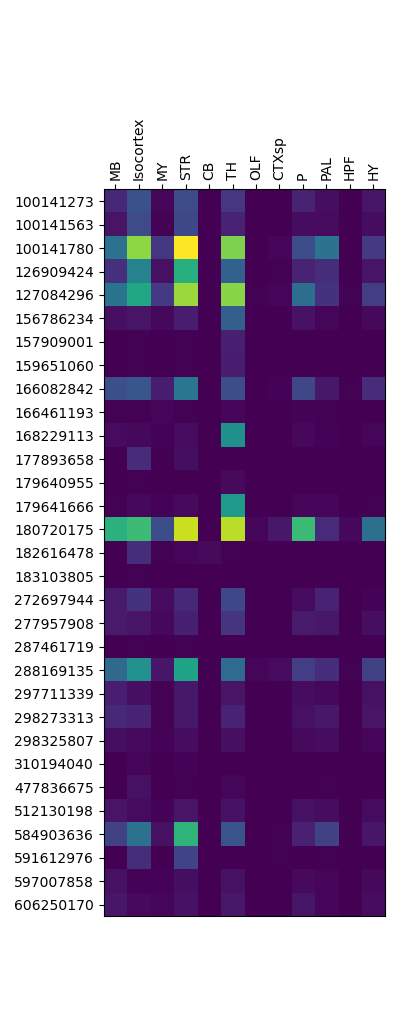

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(len(structures)/3,len(experiments)/3)

im = ax.imshow(projection_density_matrix)

ax.set_xticks(np.arange(len(structures)))
ax.set_yticks(np.arange(len(experiments)))

ax.set_xticklabels(structures, rotation=90)
ax.set_yticklabels(experiments)

ax.xaxis.tick_top()

fig.tight_layout()
plt.show()

## Download Section Images

It is also important to be able to access and view the section images for a given experiment. This can be done through the ImageDownloadApi.

In [56]:
from allensdk.api.queries.image_download_api import ImageDownloadApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityApi
import os

For a given experiment, we can access all its sections through the experiment ID.

In [57]:
ID = 503069254

We instantiate the ImageDownloadApi to download images and use the MouseConnectivityApi to access relevant data for those images, such as equalization parameters.

In [58]:
mca = MouseConnectivityApi()
ida = ImageDownloadApi()

For a given experiment, each section has a unique section_id, which we can access from its sections frame. Here, we see that this brain has been sectioned into 140 individual sections.

In [59]:
sections_frame = pd.DataFrame(ida.section_image_query(ID))

In [60]:
sections_frame

,annotated,axes,bits_per_component,data_set_id,expression,expression_path,failed,height,id,image_height,...,path,projection_function,resolution,section_number,specimen_id,structure_id,tier_count,width,x,y
0,False,None,16,503069254,None,None,False,29998,503069410,30000,...,/external/connectivity/prod426/0500336532-0122...,None,0.35,123,None,None,9,39998,1,1
1,False,None,16,503069254,None,None,False,29998,503069825,30000,...,/external/connectivity/prod426/0500336532-0082...,None,0.35,83,None,None,9,39998,1,1
2,False,None,16,503069254,None,None,False,29998,503069770,30000,...,/external/connectivity/prod426/0500336532-0087...,None,0.35,88,None,None,9,39998,1,1
3,False,None,16,503069254,None,None,False,29998,503070298,30000,...,/external/connectivity/prod426/0500336532-0036...,None,0.35,37,None,None,9,39998,1,1
4,False,None,16,503069254,None,None,False,29998,503070413,30000,...,/external/connectivity/prod426/0500336532-0027...,None,0.35,28,None,None,9,39998,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,False,None,16,503069254,None,None,False,29998,503069758,30000,...,/external/connectivity/prod426/0500336532-0089...,None,0.35,90,None,None,9,39998,1,1
136,False,None,16,503069254,None,None,False,29998,503069762,30000,...,/external/connectivity/prod426/0500336532-0088...,None,0.35,89,None,None,9,39998,1,1
137,False,None,16,503069254,None,None,False,29998,503070467,30000,...,/external/connectivity/prod426/0500336532-0021...,None,0.35,22,None,None,9,39998,1,1
138,False,None,16,503069254,None,None,False,29998,503069603,30000,...,/external/connectivity/prod426/0500336532-0101...,None,0.35,102,None,None,9,39998,1,1


We are interested in the section_id corresponding to each section, so we extract those values from the data frame.

In [61]:
section_ids = sections_frame[['section_number','id']].values

In [62]:
print(section_ids)

[[      123 503069410]
 [       83 503069825]
 [       88 503069770]
 [       37 503070298]
 [       28 503070413]
 [       49 503070144]
 [       48 503070152]
 [        6 503070614]
 [      113 503069503]
 [       51 503070136]
 [       35 503070318]
 [      130 503069350]
 [       91 503069754]
 [       47 503070162]
 [       67 503069973]
 [       24 503070455]
 [       98 503069673]
 [       95 503069700]
 [       46 503070172]
 [        9 503070592]
 [       45 503070217]
 [       63 503070006]
 [       53 503070128]
 [      121 503069429]
 [       41 503070282]
 [       13 503070566]
 [      139 503069291]
 [       12 503070570]
 [      140 503069283]
 [       40 503070286]
 [      135 503069318]
 [      134 503069323]
 [       33 503070343]
 [       16 503070543]
 [       86 503069804]
 [      116 503069467]
 [       31 503070379]
 [      108 503069559]
 [       43 503070249]
 [      119 503069447]
 [       60 503070033]
 [       66 503069981]
 [      115 503069475]
 [       44

We can access the equalization parameters from the experiment details, which we get from the MouseConnectivityApi (mca). This lets us get equalization ranges for each channel, to pass to the image downloader.

In [63]:
details = mca.get_experiment_detail(ID)
equalization_params = pd.DataFrame(details).T.loc['equalization'].values[0]
equalization_ranges = [equalization_params['red_lower'],equalization_params['red_upper'],equalization_params['green_lower'],
     equalization_params['green_upper'],equalization_params['blue_lower'],equalization_params['blue_upper']]

In [64]:
equalization_ranges

[0, 990, 0, 2962, 0, 4095]

We can now download the images. It can be convenient to put them all in a directory for that particular experiment. Then we download each individual section. In this case, we are downsampling the image by a factor of 4.

In [65]:
if not os.path.exists('./{0}/sections'.format(ID)):
    os.mkdir('./{0}/sections'.format(ID))
    
for section_number, section_id in section_ids:
    ida.download_image(section_id,downsample=4,range=equalization_ranges,
                       file_path='./{0}/sections/{1}.jpg'.format(ID,section_number))

2021-03-10 10:40:13,996 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069410?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:14,644 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069825?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:15,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069770?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:16,165 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070298?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:17,059 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070413?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:17,895 allensdk.api.api.retrieve_file_over_http 

2021-03-10 10:40:47,736 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070105?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:48,486 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069329?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:49,077 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069877?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:49,882 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070055?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:50,681 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070599?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:40:51,356 allensdk.api.api.retrieve_file_over_http 

2021-03-10 10:41:23,021 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069463?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:23,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069515?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:24,431 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503070422?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:25,218 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069596?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:26,006 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069854?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:26,758 allensdk.api.api.retrieve_file_over_http 

2021-03-10 10:41:58,244 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069861?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:59,122 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069873?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:41:59,875 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069749?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:42:00,683 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069758?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:42:01,481 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/image_download/503069762?downsample=4&range=0,990,0,2962,0,4095
2021-03-10 10:42:02,204 allensdk.api.api.retrieve_file_over_http 